In [1]:
import os
import spacy
from spacy import displacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")
import pandas as pd
#from py_thesaurus import Thesaurus

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'seek', 'can', 'the', 'a', 'this', 'its', 'as', 'such', 'fund', 'investment', 'invest', 'asset', 'portfolio', 'equity', 'aim'])
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'seek', 'can', 'the', 'a', 'this', 'its', 'as', 'such', 'invest', 'aim'])

import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import re

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

## Load Data

In [5]:
kiid2table = pd.read_excel("./outputs/kiid8000/kiidoc2table.xlsx")
kiid2table.head()

Unnamed: 0                                          name_file  \
0           0  KIIDOC-2019-12-20-EN-CH-2020-01-06-157241-0900...   
1           0  KIIDOC-2020-02-19-EN-GB-2020-02-17-283156-0900...   
2           0  KIIDOC-2019-05-22-EN-00-2019-05-21-339044-0900...   
3           0  KIIDOC-2019-06-17-EN-00-2019-06-17-330896-0900...   
4           0  KIIDOC-2020-02-28-EN-GB-2020-02-28-358013-0900...   

    share_class                        subfund         umbrella_fund  \
0  LU0823429740                   India Equity     BNP Paribas Funds   
1  LU1664645287                           Aqua     BNP Paribas Funds   
2  LU1981115113  Invesco US Value Equity Fund        Invesco Funds     
3  LU1934329050     Invesco ASEAN Equity Fund         Invesco Funds    
4  LU2066071577                     SMaRT Food     BNP Paribas Funds   

                                          objectives  \
0    The Fund seeks to increase the value of its ...   
1    The Fund seeks to increase the value of its ...   
2    The objective of the Fund is to achieve long...   
3    The objective of the Fund is to achieve long...   
4    The Fund seeks to increase the value of its ...   

                                               risks  \
0    Lower risk Higher risk Other risks materiall...   
1    Lower risk Higher risk Other risks materiall...   
2    Other RisksLower Risk Higher Risk n The valu...   
3    Other RisksLower Risk Higher Risk n The valu...   
4    Lower risk Higher risk Other risks materiall...   

                                         description  \
0  Key Investor InformationThis document provides...   
1  Key Investor InformationThis document provides...   
2  Key Investor Information This document provide...   
3  Key Investor Information This document provide...   
4  Key Investor InformationThis document provides...   

                                                   0  
0   BNP PARIBAS ASSET MANAGEMENT Luxembourg, part...  
1   BNP PARIBAS ASSET MANAGEMENT Luxembourg, part...  
2   Invesco Management S.A., part of the Invesco ...  
3   Invesco Management S.A., part of the Invesco ...  
4   BNP PARIBAS ASSET MANAGEMENT Luxembourg, part...

In [66]:
kiid2terms = pd.read_excel("./outputs/kiid8000/kiidoc2terms.xlsx")
kiid2terms.head()

Unnamed: 0    # type                                 key  pattern  \
0         0.0  1.0    T                 nn: investment team      N N   
1         1.0  2.0    T              nnn: bank business day    N N N   
2         2.0  3.0    T   annn: bnp pariba asset management  A N N N   
3         3.0  4.0    T             npn: investment of fund    N P N   
4         4.0  5.0    T  ann: sustainable investment policy    A N N   

  Unnamed: 5                          pilot  spec    freq   dFreq  ...  \
0          1                investment team  5,10  2531.0  2447.0  ...   
1          0             bank business days  5,09  2471.0  2460.0  ...   
2          0   BNP PARIBAS ASSET MANAGEMENT  5,08  2456.0  2456.0  ...   
3        NaN        investments of the Fund  5,08  2447.0  2447.0  ...   
4        NaN  Sustainable Investment Policy  5,07  2375.0  2375.0  ...   

  Relation is_a restrictions  has  is_part of attribute Unnamed: 20  \
0      NaN               NaN  NaN         NaN       NaN         NaN   
1      NaN               NaN  NaN         NaN       NaN         NaN   
2      NaN               NaN  NaN         NaN       NaN         NaN   
3      NaN               NaN  NaN         NaN       NaN         NaN   
4      NaN               NaN  NaN         NaN       NaN         NaN   

          synonyme entity entity2  \
0              NaN    NaN     NaN   
1              NaN    NaN     NaN   
2              NaN    NaN     NaN   
3  fund_investment    NaN     NaN   
4              NaN    NaN     NaN   

                                         kiidoc_list  
0  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
1  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
2  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
3  ['LU0823438816', 'LU1956155193', 'LU1920352793...  
4  ['LU0823438816', 'LU1956155193', 'LU1920352793...  

[5 rows x 25 columns]

## Split train - test

### Clean and tokenize text

In [101]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = X_train.objectives.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['the', 'fund', 'seeks', 'to', 'increase', 'the', 'value', 'of', 'its', 'assets', 'over', 'the', 'medium', 'term', 'by', 'investing', 'in', 'bonds', 'and', 'or', 'other', 'debt', 'instruments', 'issued', 'by', 'emerging', 'countries', 'and', 'or', 'companies', 'from', 'emerging', 'countries', 'or', 'companies', 'operating', 'in', 'these', 'countries', 'after', 'hedging', 'the', 'exposure', 'to', 'currencies', 'other', 'than', 'usd', 'may', 'not', 'exceed', 'it', 'is', 'actively', 'managed', 'and', 'as', 'such', 'may', 'invest', 'in', 'securities', 'that', 'are', 'not', 'included', 'in', 'the', 'index', 'which', 'is', 'jpm', 'embi', 'global', 'diversified', 'ri', 'the', 'investment', 'team', 'applies', 'also', 'bnp', 'paribas', 'asset', 'management', 'sustainable', 'investment', 'policy', 'which', 'takes', 'into', 'account', 'environmental', 'social', 'and', 'governance', 'esg', 'criteria', 'in', 'the', 'investments', 'of', 'the', 'fund', 'income', 'are', 'systematically', 'reinvested'

## If you already have a list of keywords:

In [2]:
# Load Data:
keywords = pd.read_excel("./outputs/lda/dominant_topic.xlsx")
keywords.head()

Unnamed: 0  Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0           0            0               9              0.9046   
1           1            1              19              0.9928   
2           2            2               2              0.8858   
3           3            3               2              0.9837   
4           4            4              19              0.9929   

                                            Keywords  \
0  company, medium, include, basis, index, bank, ...   
1  share, china, investor, environmental, sustain...   
2  share, objective, company, income, define, sel...   
3  share, objective, company, income, define, sel...   
4  share, china, investor, environmental, sustain...   

                                                Text  
0  ['increase', 'value', 'medium', 'term', 'share...  
1  ['increase', 'value', 'medium', 'term', 'share...  
2  ['objective', 'achieve', 'long', 'term', 'capi...  
3  ['objective', 'achieve', 'long', 'term', 'capi...  
4  ['increase', 'value', 'medium', 'term', 'share...

In [3]:
keywords_list = [text for text in keywords.Text]

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(keywords_list, min_count=5, threshold=1) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[keywords_list], threshold=1)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en')
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        #texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        texts_out.append([token.lemma_ for token in doc for ent in doc.ents if token.pos_ in "NOUN" and token.text != ent.text])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

#data_ready = process_words(data_words)  # processed Text Data!
data_ready = process_words(keywords_list) # processed list of keywords

### Construct a term-term matrix:
list of terms as rows and list of terms as column. for each term, calculate tfidf.


In [10]:

import gensim
model2 = gensim.models.Word2Vec(data_ready, min_count=2)

In [12]:
print(model2.similarity('index', 'msci'))

0.84490657


/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [14]:
print(model2.similarity('msci', 'msci'))

1.0


/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [15]:
print(model2.most_similar("msci"))

[('world', 0.9237245321273804), ('authority', 0.9175320267677307), ('russell', 0.8818286061286926), ('bel', 0.8599191308021545), ('brazil', 0.8589286208152771), ('russia', 0.8576740622520447), ('index', 0.8449065685272217), ('india', 0.8347444534301758), ('topix', 0.8243203163146973), ('cap', 0.8183319568634033)]


/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [9]:
print(model.most_similar("index"))

[('msci', 0.8730132579803467), ('security', 0.8663842678070068), ('world', 0.8312753438949585), ('eonia', 0.8248528242111206), ('russell', 0.8105134963989258), ('jpm', 0.8080782294273376), ('midcap', 0.7993489503860474), ('team', 0.7992018461227417), ('barclay', 0.7788852453231812), ('authority', 0.7785844802856445)]


/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [10]:
print(model.most_similar("currency"))

[('behave_like', 0.8459671139717102), ('analysis', 0.8297125697135925), ('sub', 0.8181246519088745), ('avoid', 0.7995981574058533), ('yield', 0.7537754774093628), ('mix', 0.7314464449882507), ('determine', 0.730640172958374), ('default', 0.7277199029922485), ('ice', 0.7234827876091003), ('hedge', 0.7225753664970398)]


/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [11]:
print(model.most_similar("generate"))

[('amount', 0.9894945621490479), ('leverage', 0.9652774930000305), ('reduce', 0.949547529220581), ('gain', 0.9453645348548889), ('risk', 0.9219737648963928), ('order', 0.9216848611831665), ('position', 0.9169760942459106), ('capital', 0.9013932347297668), ('loan', 0.8617162704467773), ('lesser_extent', 0.8573395013809204)]


/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


## K-means

In [12]:
X = model[model.wv.vocab]

/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [13]:
print(X)

[[-0.25599355 -0.06832966 -0.36642858 ...  0.19427748  0.31704575
   0.2804693 ]
 [ 0.14358942  0.19207832 -0.38780233 ... -0.0964192   0.58071357
   0.4952538 ]
 [ 0.1555692   0.37177488 -0.4659786  ...  0.0533296   0.41311133
   0.39917234]
 ...
 [-0.00132555  0.06927396  0.02554924 ... -0.03549528  0.00771671
   0.05557369]
 [ 0.0071591   0.03364421  0.01238751 ... -0.01571302  0.01632671
   0.02542863]
 [-0.01099564  0.01099164  0.00333949 ... -0.01193829  0.01662427
   0.02318548]]


In [104]:
NUM_CLUSTERS = 8

In [105]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[3 1 3 3 1 3 1 3 7 3 7 7 7 7 7 7 1 7 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 4 4 4 4
 4 4 4 4 4 4 1 1 1 1 1 1 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 7 7 7 2 2 6 3 3 3
 3 3 1 1 1 1 6 6 6 6 4 4 1 1 1 1 1 1 1 1 1 6 1 1 7 0 0 0 0 0 0 0 0 1 0 0 1
 0 1 0 0 0 0 7 1 0 5 6 6 1 1 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 1 0 3 3 0 3 0 0
 6 6 6 6 6 6 6 6 1 1 7 1 1 1 1 5 1 0 3 7 1 5 5 5 5 5 1 1 1 1 3 1 7 2 7 7 7
 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 7 3 7 3 3 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 4 1
 1 1 0 3 1 1 3 1 3 1 1 1 1 1 1 1 1 1 1 7 7 7 1 1 1 3 3 7 1 1 1 1 1 1 4 0 0
 0 0 0 1 1 7 1 1 1 7 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 3
 1 1 1 1 1 1 1 1 1 0 0 0 5 7 1 7 1 1 7 1 1 7 7 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1

## PCA

In [34]:
dir_out = "./outputs/term_clustering/"

/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


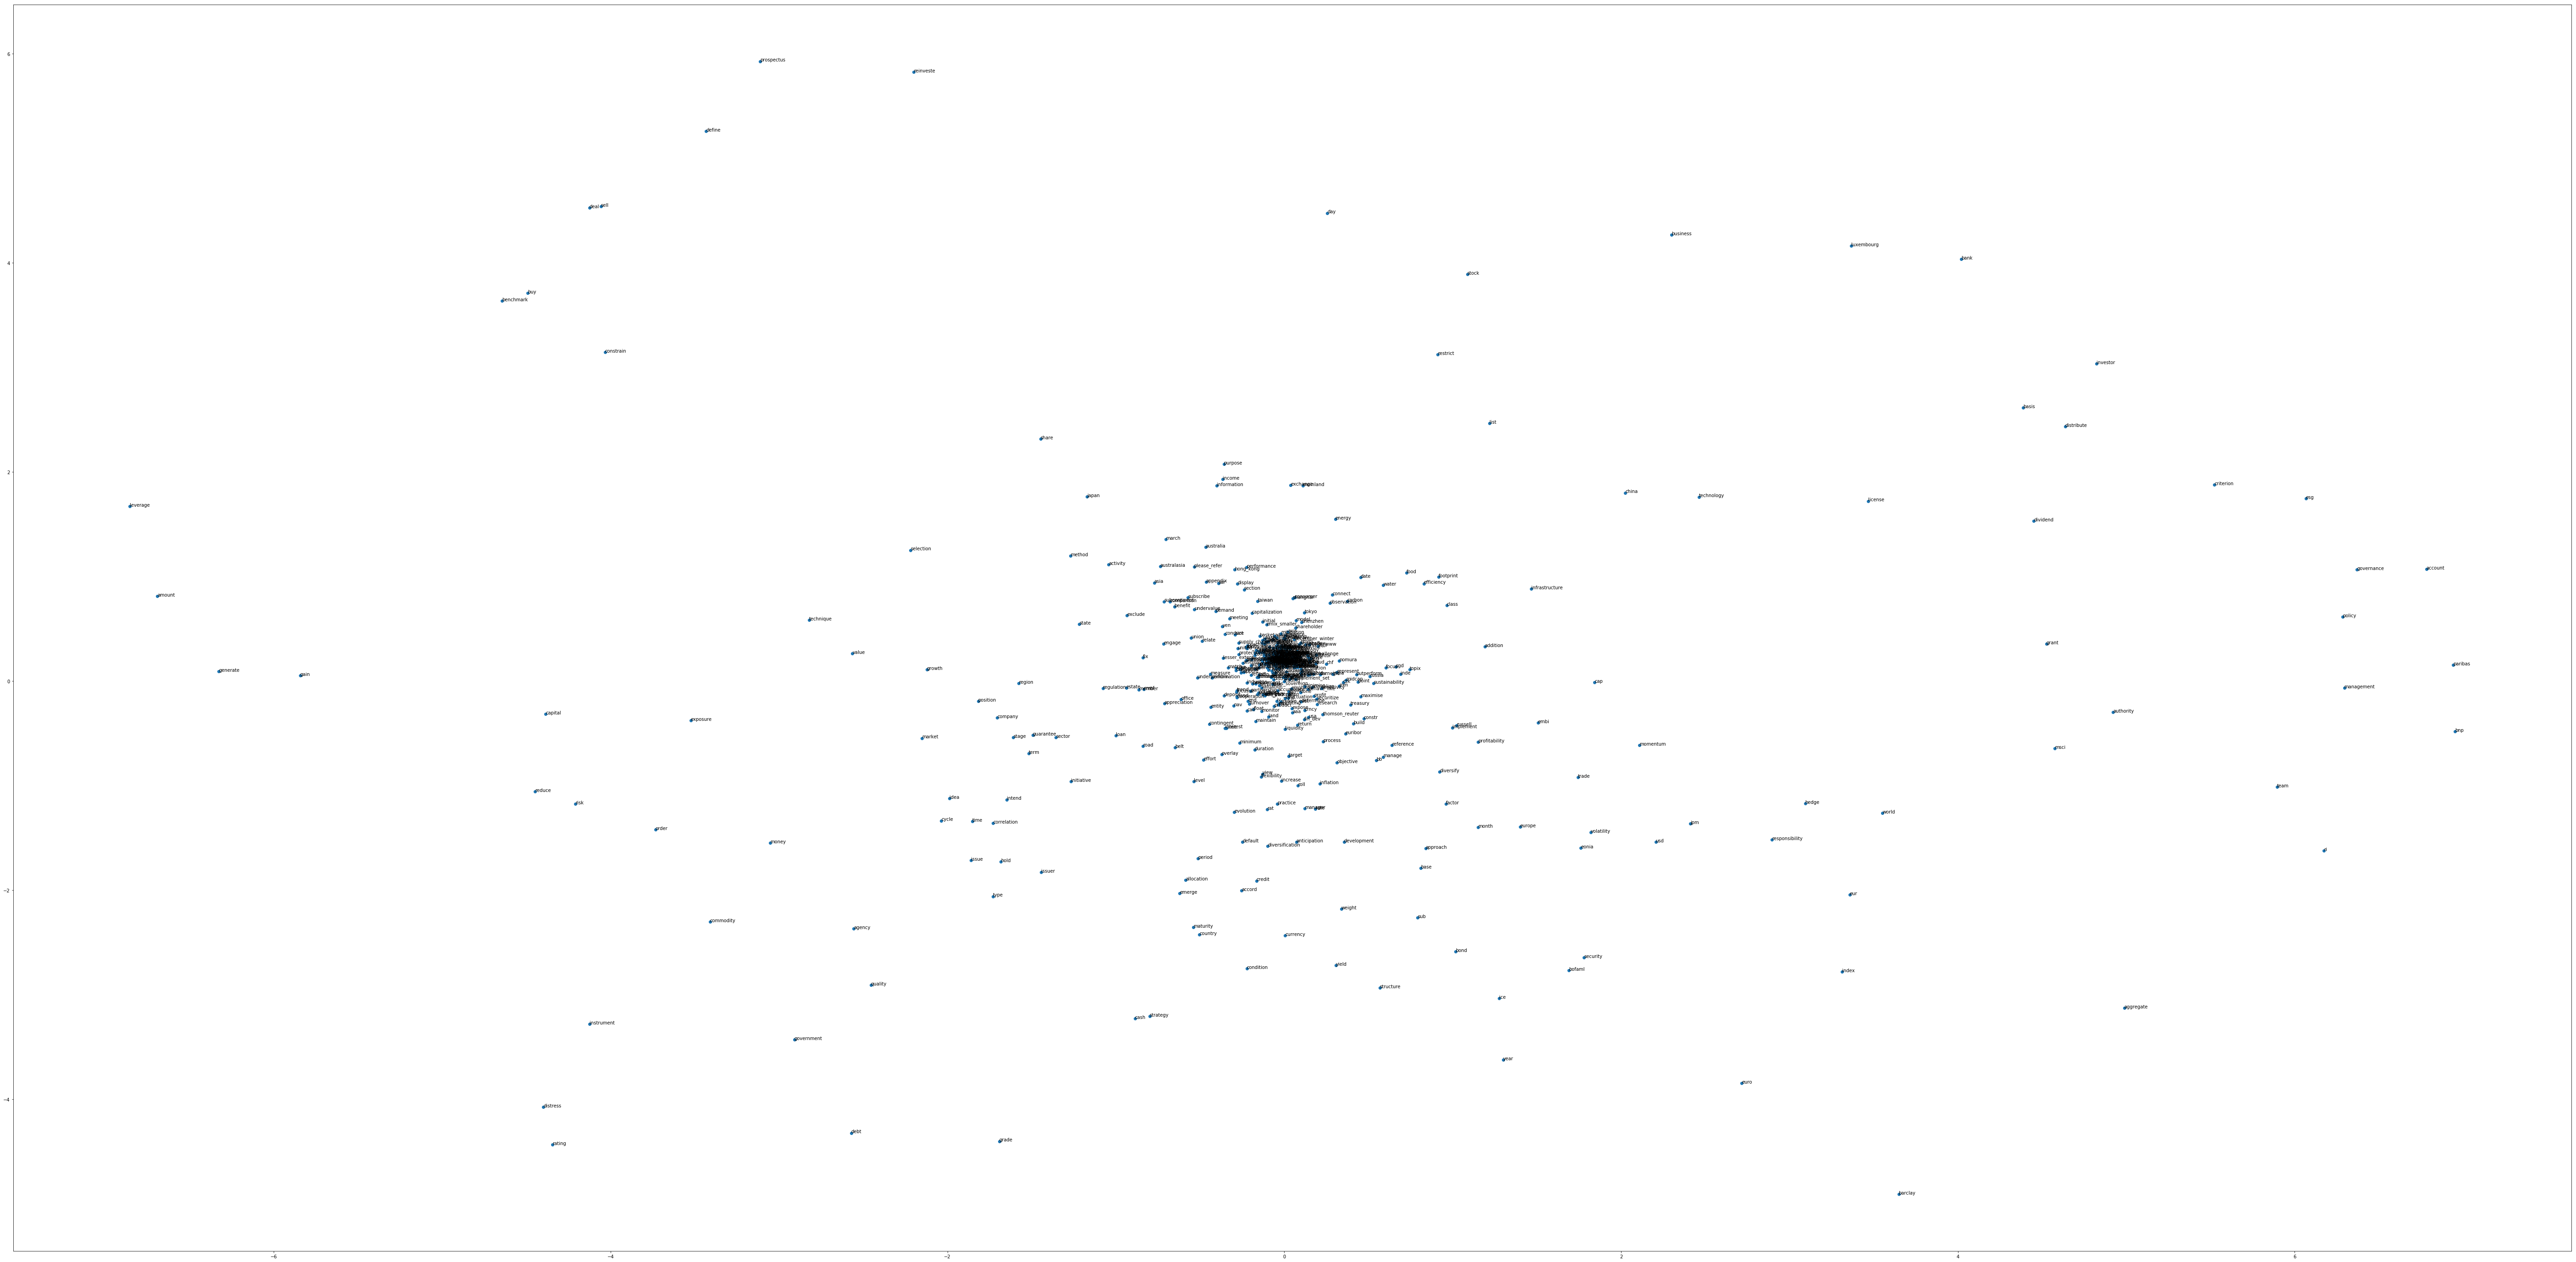

In [14]:

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.figure(figsize=(100,50))
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
#
#plt.savefig(dir_out+'PCA terms.png')
pyplot.show()

## Hierarchical Clustering

/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


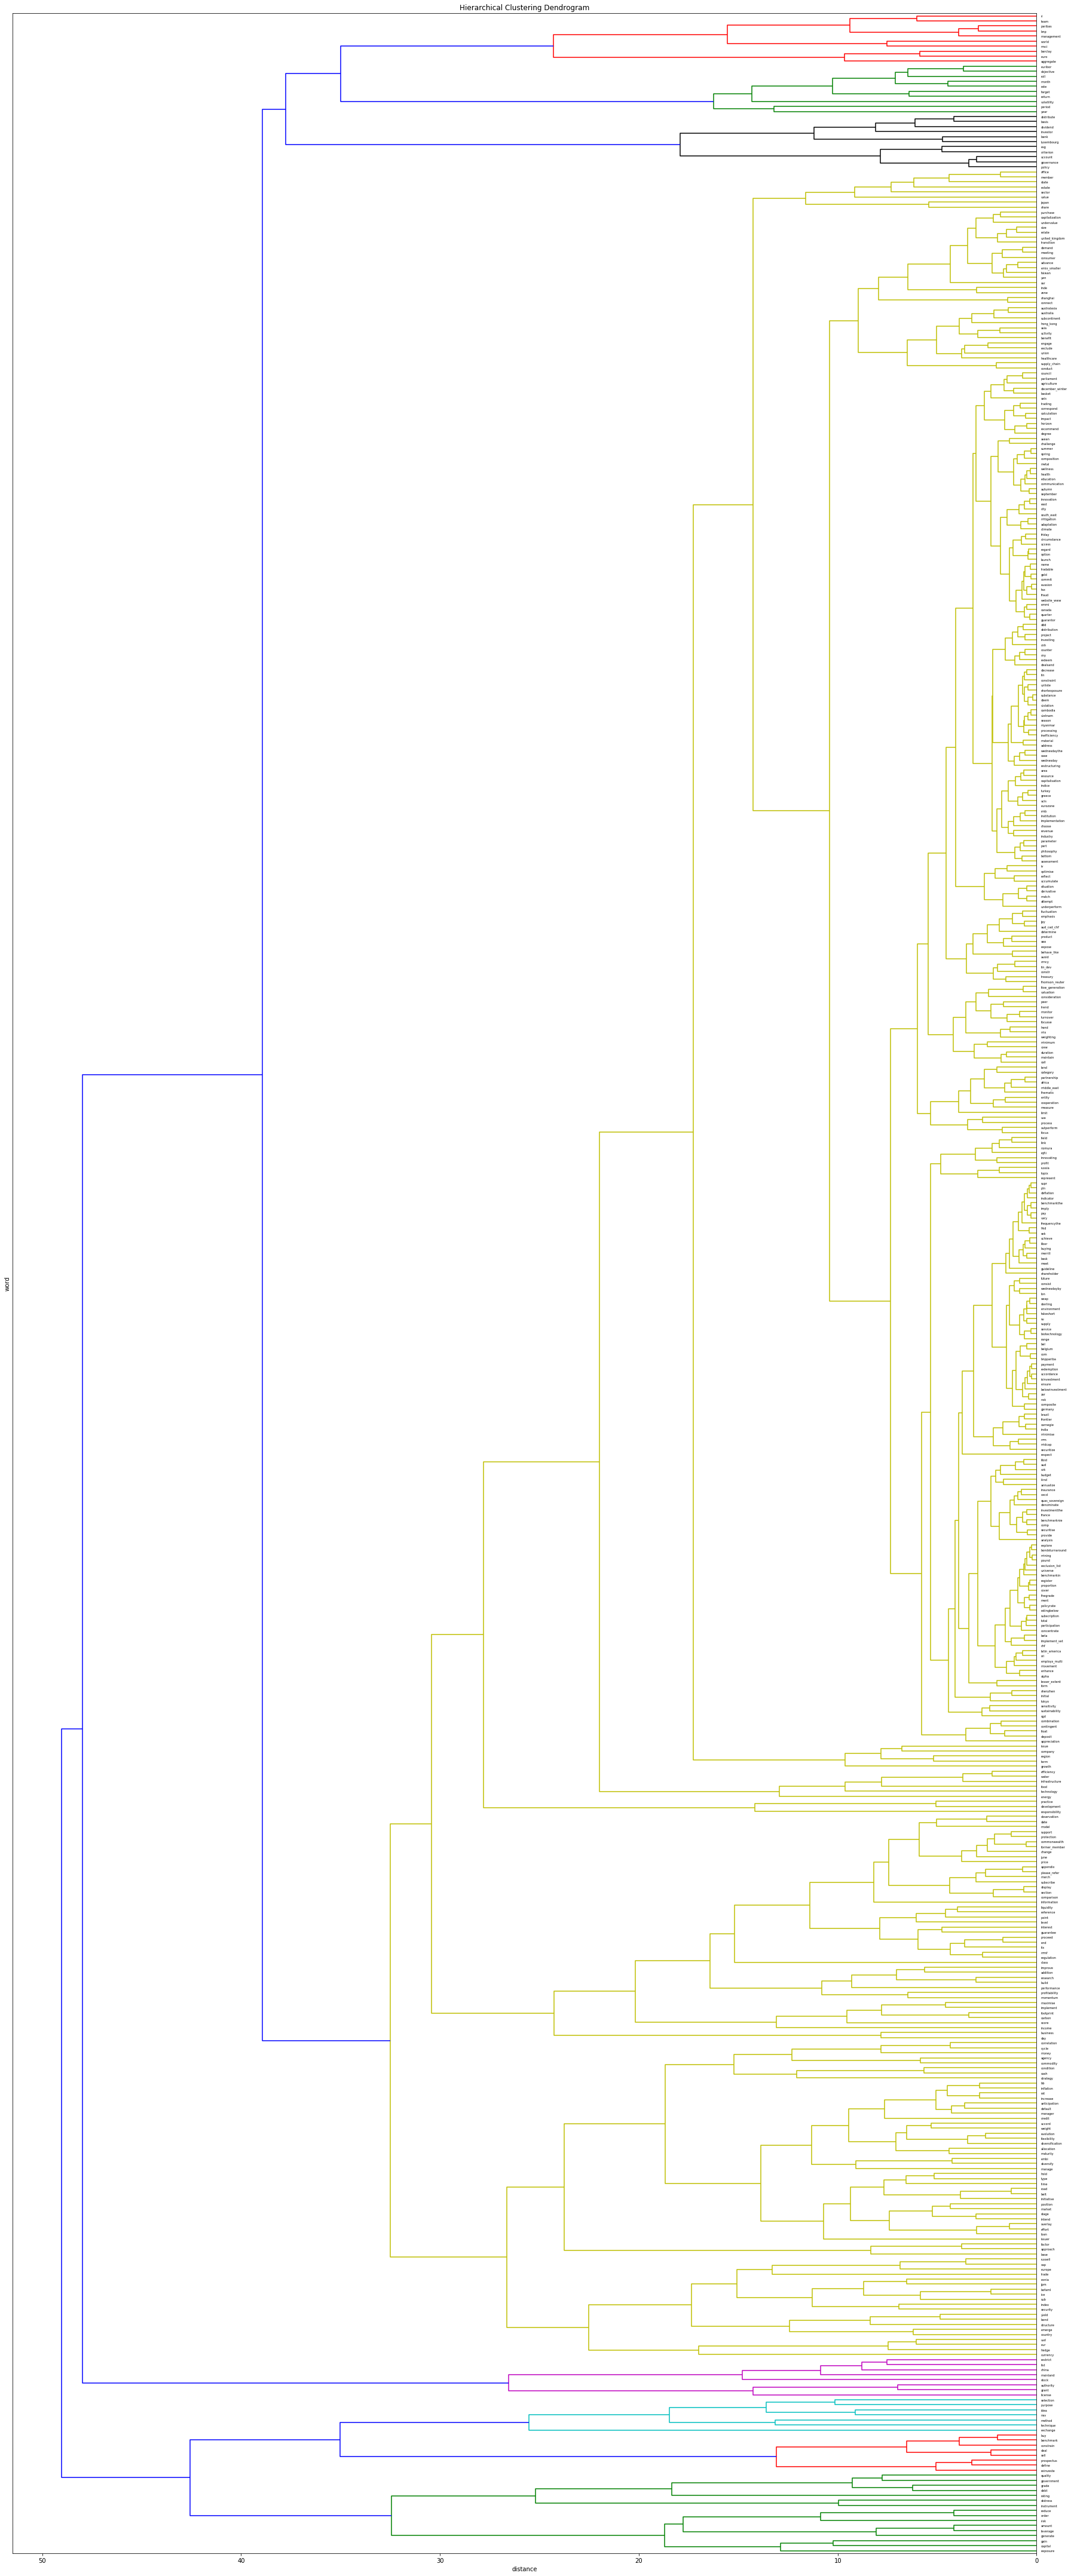

In [15]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

l = linkage(model.wv.syn0, method='complete', metric='seuclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 60))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    #leaf_rotation=90.,  # rotates the x axis labels
    #leaf_font_size=16.,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(model.wv.index2word[v])
)
plt.tight_layout()
#plt.savefig(dir_out+'hierarchy_term.png', dpi=200)
plt.savefig('./out_test/hierarchy_term.png', dpi=200)
plt.show()


## LSA & SVD

sources: https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8

In [118]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

import seaborn as sns

In [107]:
X_train = term2vec

In [124]:
tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words=stop_words, 
                        #tokenizer=tokenizer.tokenize, 
                        max_df=0.2,
                        min_df=0.02
                       )
tfidf_train_sparse = tfidf.fit_transform(X_train)
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_train_df.head()

accord  activity  agency  aggregate  allocation  annually  approach  asia  \
0     0.0       0.0     0.0        0.0         0.0  0.000000       0.0   0.0   
1     0.0       0.0     0.0        0.0         0.0  0.000000       0.0   0.0   
2     0.0       0.0     0.0        0.0         0.0  0.000000       0.0   0.0   
3     0.0       0.0     0.0        0.0         0.0  0.597191       0.0   0.0   
4     0.0       0.0     0.0        0.0         0.0  0.000000       0.0   0.0   

   asian  authority  ...  typically  usa       usd  various  volatility  \
0    0.0        0.0  ...        0.0  0.0  0.217045      0.0         0.0   
1    0.0        0.0  ...        0.0  0.0  0.000000      0.0         0.0   
2    0.0        0.0  ...        0.0  0.0  0.000000      0.0         0.0   
3    0.0        0.0  ...        0.0  0.0  0.000000      0.0         0.0   
4    0.0        0.0  ...        0.0  0.0  0.118081      0.0         0.0   

   water  weight     world  year  yield  
0    0.0     0.0  0.000000   0.0    0.0  
1    0.0     0.0  0.343047   0.0    0.0  
2    0.0     0.0  0.000000   0.0    0.0  
3    0.0     0.0  0.000000   0.0    0.0  
4    0.0     0.0  0.117699   0.0    0.0  

[5 rows x 205 columns]

In [125]:
X_test = term2vec_test

In [127]:
tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words=stop_words, 
                        #tokenizer=tokenizer.tokenize, 
                        max_df=0.2,
                        min_df=0.02
                       )
tfidf_test_sparse = tfidf.fit_transform(X_test)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_test_df.head()

accord  activity  addition  additional  agency  aggregate  allocation  \
0     0.0       0.0       0.0     0.27775     0.0        0.0         0.0   
1     0.0       0.0       0.0     0.00000     0.0        0.0         0.0   
2     0.0       0.0       0.0     0.00000     0.0        0.0         0.0   
3     0.0       0.0       0.0     0.00000     0.0        0.0         0.0   
4     0.0       0.0       0.0     0.00000     0.0        0.0         0.0   

   annually  anticipation  appreciation  ...     union  usa  usd  various  \
0  0.351728           0.0           0.0  ...  0.000000  0.0  0.0      0.0   
1  0.000000           0.0           0.0  ...  0.296967  0.0  0.0      0.0   
2  0.000000           0.0           0.0  ...  0.296967  0.0  0.0      0.0   
3  0.000000           0.0           0.0  ...  0.000000  0.0  0.0      0.0   
4  0.000000           0.0           0.0  ...  0.000000  0.0  0.0      0.0   

   volatility  weight    world  year  yield      zone  
0    0.000000     0.0  0.00000   0.0    0.0  0.000000  
1    0.000000     0.0  0.00000   0.0    0.0  0.318003  
2    0.000000     0.0  0.00000   0.0    0.0  0.318003  
3    0.000000     0.0  0.00000   0.0    0.0  0.000000  
4    0.442334     0.0  0.89685   0.0    0.0  0.000000  

[5 rows x 190 columns]

In [128]:
from sklearn.decomposition import TruncatedSVD
lsa_obj = TruncatedSVD(n_components=20, n_iter=100, random_state=42)
tfidf_lsa_data = lsa_obj.fit_transform(tfidf_train_df)
Sigma = lsa_obj.singular_values_
V_T = lsa_obj.components_.T

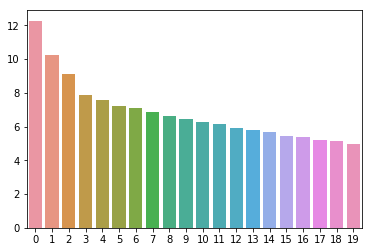

In [129]:
sns.barplot(x=list(range(len(Sigma))), y = Sigma)

In [136]:
term_topic_matrix = pd.DataFrame(data=Sigma,#lsa_term_topic, 
                                 index = tfidf_train_df.columns, 
                                 columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])

ValueError: Shape of passed values is (20, 1), indices imply (205, 20)

In [84]:

#X = sparse_random(100, 100, density=0.01, format='csr',random_state=42)
X = model[model.wv.vocab]
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X)
TruncatedSVD(n_components=5, n_iter=7, random_state=42)
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

print(svd.singular_values_)

[0.24762313 0.18527062 0.13946107 0.07023711 0.07704294]
0.71963483
[52.424023 45.680107 39.065666 34.56175  32.574646]


/Users/airbooklea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


## Terms Cleaning

In [20]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
import spacy
nlp = spacy.load('en')

import requests
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup

import pandas as pd
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/airbooklea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Clean the term table:

# extract of???
    #shares of --> companies have shares
    # if terms exist in list, it's a relation
#extract with???
    #companies with minimum rating --> companies have_rating minimum
#if "&" replace by "and"
#delete "the", "a", "an"
# "-" if it ends or begins the term

In [67]:
kiid2terms["pilot"] = kiid2terms["pilot"].replace("&","and")
kiid2terms["pilot"] = kiid2terms["pilot"].replace("( a )|( an )", "")
kiid2terms["pilot"] = kiid2terms["pilot"].replace("^\-|\-$","")

In [68]:
# Extract terms that express relations (terms that contain "of", "with")

subj_obj_df = kiid2terms["pilot"].str.extractall(r"(?P<object>[\W\w]+) of the (?P<subject>[\W\w]+)")
indexNames = kiid2terms[ kiid2terms['pilot'].str.contains(" of the ") ].index 
kiid2terms.drop(indexNames , inplace=True)

obj_subj_df = kiid2terms["pilot"].str.extractall(r"(?P<subject>[\W\w]+) with (?P<object>[\W\w]+)")
indexNames = kiid2terms[ kiid2terms['pilot'].str.contains(" with ") ].index 
kiid2terms.drop(indexNames , inplace=True)

of_df = kiid2terms["pilot"].str.extractall(r"(?P<object>[\W\w]+) of (?P<subject>[\W\w]+)")
indexNames = kiid2terms[ kiid2terms['pilot'].str.contains(" of ") ].index 
kiid2terms.drop(indexNames , inplace=True)
of_df


object             subject
    match                                      
10  0      debt instruments             issuers
17  0                shares           companies
18  0                shares  Japanese companies
19  0                shares     small companies
20  0                shares  European companies
...                     ...                 ...
731 0                  size     large companies
754 0             companies  European companies
823 0          Commonwealth  Independent States
839 0                  rate              return
885 0                 level           inflation

[72 rows x 2 columns]

In [69]:
# subj_obj_df and of_df columns must be inversed to concatenate with obj_subj_df

subj_obj_df.iloc[:, ::-1]
of_df.iloc[:, ::-1]

subject            object
    match                                      
10  0                 issuers  debt instruments
17  0               companies            shares
18  0      Japanese companies            shares
19  0         small companies            shares
20  0      European companies            shares
...                       ...               ...
731 0         large companies              size
754 0      European companies         companies
823 0      Independent States      Commonwealth
839 0                  return              rate
885 0               inflation             level

[72 rows x 2 columns]

In [70]:
concat_subj_obj = pd.concat([obj_subj_df, subj_obj_df, of_df])
concat_subj_obj

subject               object
    match                                         
122 0             medium term  a target volatility
148 0               companies     a minimum rating
232 0                deposits  credit institutions
239 0            market cycle                a low
251 0                     USD  an average maturity
...                       ...                  ...
731 0         large companies                 size
754 0      European companies            companies
823 0      Independent States         Commonwealth
839 0                  return                 rate
885 0               inflation                level

[147 rows x 2 columns]

In [71]:
concat_subj_obj.to_excel("./outputs/concat_subj_obj.xlsx")

In [50]:
# first: identify which entities are named entities

In [72]:
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def pos_tag(text):
    doc = nlp(text)
    return " ".join([token.pos_ for token in doc])

def name_entity(text):
    doc = nlp(text)
    return " ".join([ent.label_ for ent in doc.ents])

In [73]:
kiid2terms["entity"] = kiid2terms["pilot"].apply(name_entity)
kiid2terms["pos_tag"] = kiid2terms["pilot"].apply(pos_tag)
kiid2terms

Unnamed: 0       # type                                    key  pattern  \
0           0.0     1.0    T                    nn: investment team      N N   
1           1.0     2.0    T                 nnn: bank business day    N N N   
2           2.0     3.0    T      annn: bnp pariba asset management  A N N N   
4           4.0     5.0    T     ann: sustainable investment policy    A N N   
5           7.0     8.0    T  ncnn: objective and investment policy  N C N N   
..          ...     ...  ...                                    ...      ...   
978      1170.0  1088.0    T                             r: equally        R   
979      1173.0  1091.0    T                           n: community        N   
980      1176.0  1094.0    T                         n: restriction        N   
981      1177.0  1095.0    T                            n: industry        N   
982      1178.0  1096.0    T                              n: france        N   

    Unnamed: 5                             pilot  spec    freq   dFreq  ...  \
0            1                   investment team  5,10  2531.0  2447.0  ...   
1            0                bank business days  5,09  2471.0  2460.0  ...   
2            0      BNP PARIBAS ASSET MANAGEMENT  5,08  2456.0  2456.0  ...   
4          NaN     Sustainable Investment Policy  5,07  2375.0  2375.0  ...   
5          NaN  Objectives and Investment Policy  4,94  3494.0  3491.0  ...   
..         ...                               ...   ...     ...     ...  ...   
978        NaN                           equally  0,05     3.0     3.0  ...   
979  sub-class                       communities  0,04     9.0     9.0  ...   
980        NaN                      restrictions  0,04     1.0     1.0  ...   
981        NaN                          industry  0,03    11.0    10.0  ...   
982        NaN                            France  0,03     6.0     6.0  ...   

    is_a restrictions  has  is_part of  attribute Unnamed: 20  \
0                 NaN  NaN         NaN        NaN         NaN   
1                 NaN  NaN         NaN        NaN         NaN   
2                 NaN  NaN         NaN        NaN         NaN   
4                 NaN  NaN         NaN        NaN         NaN   
5                 NaN  NaN         NaN        NaN         NaN   
..                ...  ...         ...        ...         ...   
978               NaN  NaN         NaN        NaN         NaN   
979               NaN  NaN         NaN        NaN         NaN   
980               NaN  NaN         NaN        NaN         NaN   
981               NaN  NaN         NaN        NaN         NaN   
982               NaN  NaN         NaN        NaN         NaN   

                  synonyme  entity entity2  \
0                      NaN             NaN   
1                      NaN             NaN   
2                      NaN     ORG     NaN   
4                      NaN             NaN   
5    objective of the Fund             NaN   
..                     ...     ...     ...   
978                    NaN             NaN   
979                    NaN             NaN   
980                    NaN             NaN   
981                    NaN             NaN   
982                    NaN     GPE     NaN   

                                           kiidoc_list                 pos_tag  
0    ['LU0823438816', 'LU1956155193', 'LU1920352793...               NOUN NOUN  
1    ['LU0823438816', 'LU1956155193', 'LU1920352793...          NOUN NOUN NOUN  
2    ['LU0823438816', 'LU1956155193', 'LU1920352793...   PROPN PROPN NOUN NOUN  
4    ['LU0823438816', 'LU1956155193', 'LU1920352793...       PROPN PROPN PROPN  
5                                                   []  NOUN CCONJ PROPN PROPN  
..                                                 ...                     ...  
978                                                NaN                     ADV  
979                                                NaN                    NOUN  
980                             

In [58]:
# second: for terms who are not NE, apply preprocessing

In [74]:
mask = kiid2terms["entity"] == ""

In [75]:
kiid2terms.loc[mask, "pilot"] = kiid2terms["pilot"].str.replace(" ","_")
kiid2terms.loc[mask, "pilot"] = kiid2terms["pilot"].str.replace("-","_")
kiid2terms.loc[mask, "pilot"] = kiid2terms["pilot"].str.lower()

In [77]:
kiid2terms.head(20)

Unnamed: 0     #  type                                    key  pattern  \
0          0.0   1.0     T                    nn: investment team      N N   
1          1.0   2.0     T                 nnn: bank business day    N N N   
2          2.0   3.0     T      annn: bnp pariba asset management  A N N N   
4          4.0   5.0     T     ann: sustainable investment policy    A N N   
5          7.0   8.0     T  ncnn: objective and investment policy  N C N N   
7         10.0  11.0     T                    nn: debt instrument      N N   
8         11.0  11.0  V[s]        ann: structured debt instrument    A N N   
9         12.0  11.0  V[s]        ann: equivalent debt instrument    A N N   
11        14.0  11.0  V[s]           ann: unrated debt instrument    A N N   
12        15.0  11.0  V[s]    nnn: non-government debt instrument    N N N   
13        16.0  11.0  V[s]     annn: high quality debt instrument  A N N N   
14        17.0  11.0  V[s]  ann: euro-denominated debt instrument    A N N   
15        18.0  12.0     T                             n: hedging        N   
16        19.0  13.0     T                 an: complex instrument      A N   
26         NaN   NaN     T                   nn: investment grade      N N   
27        30.0  15.0     T                   nn: investment grade      N N   
28        31.0  15.0  V[s]             nnn: investment grade bond    N N N   
29        32.0  16.0     T               nn: investment objective      N N   
30        34.0  16.0  V[s]     nnn: sub-fund investment objective    N N N   
31        35.0  14.0     T              ann: mainland china share    A N N   

   Unnamed: 5                              pilot                     spec  \
0           1                    investment_team                     5,10   
1           0                 bank_business_days                     5,09   
2           0       BNP PARIBAS ASSET MANAGEMENT                     5,08   
4         NaN      sustainable_investment_policy                     5,07   
5         NaN   objectives_and_investment_policy                     4,94   
7           1                   debt_instruments                     4,66   
8   Sub-Class        structured_debt_instruments                     3,49   
9   Sub-Class        equivalent_debt_instruments                     2,60   
11  Sub-Class           unrated_debt_instruments                     3,11   
12  Sub-Class    non_government_debt_instruments                     3,02   
13  Sub-Class      high_quality_debt_instruments                     3,23   
14  Sub-Class  euro_denominated_debt_instruments                     2,81   
15        NaN                            hedging                     4,42   
16  Sub-class                complex_instruments                     4,42   
26  Sub-Class                   investment_grade  debt instrument, rating   
27  Sub-Class                   investment_grade                     4,40   
28          1             investment_grade_bonds                     3,81   
29          1              investment_objectives                     4,40   
30        NaN      sub_fund_investment_objective                     2,47   
31        NaN              Mainland China shares                     4,38   

      freq   dFreq  ... is_a restrictions                has  \
0   2531.0  2447.0  ...               NaN                NaN   
1   2471.0  2460.0  ...               NaN                NaN   
2   2456.0  2456.0  ...               NaN                NaN   
4   2375.0  2375.0  ...               NaN                NaN   
5   3494.0  3491.0  ...               NaN                NaN   
7   1854.0  1093.0  ...               NaN  (some) volatility   
8     63.0    63.0  ...               NaN                NaN   
9      8.0     8.0  ...               NaN                NaN   
11    26.0    26.0  ...               NaN                NaN   
12    21.0    21.0  ...               NaN                NaN   
13    34.0    34.0  ...               NaN  

In [78]:
kiid2terms.to_excel("./outputs/kiid2terms.xlsx")

In [79]:
kiid2concept = kiid2terms.loc[mask, :]
kiid2concept

Unnamed: 0       # type                                    key  pattern  \
0           0.0     1.0    T                    nn: investment team      N N   
1           1.0     2.0    T                 nnn: bank business day    N N N   
4           4.0     5.0    T     ann: sustainable investment policy    A N N   
5           7.0     8.0    T  ncnn: objective and investment policy  N C N N   
7          10.0    11.0    T                    nn: debt instrument      N N   
..          ...     ...  ...                                    ...      ...   
977      1169.0  1087.0    T                         n: shareholder        N   
978      1170.0  1088.0    T                             r: equally        R   
979      1173.0  1091.0    T                           n: community        N   
980      1176.0  1094.0    T                         n: restriction        N   
981      1177.0  1095.0    T                            n: industry        N   

    Unnamed: 5                             pilot  spec    freq   dFreq  ...  \
0            1                   investment_team  5,10  2531.0  2447.0  ...   
1            0                bank_business_days  5,09  2471.0  2460.0  ...   
4          NaN     sustainable_investment_policy  5,07  2375.0  2375.0  ...   
5          NaN  objectives_and_investment_policy  4,94  3494.0  3491.0  ...   
7            1                  debt_instruments  4,66  1854.0  1093.0  ...   
..         ...                               ...   ...     ...     ...  ...   
977        NaN                       shareholder  0,06     6.0     6.0  ...   
978        NaN                           equally  0,05     3.0     3.0  ...   
979  sub-class                       communities  0,04     9.0     9.0  ...   
980        NaN                      restrictions  0,04     1.0     1.0  ...   
981        NaN                          industry  0,03    11.0    10.0  ...   

    is_a restrictions                has               is_part of  attribute  \
0                 NaN                NaN                      NaN        NaN   
1                 NaN                NaN                      NaN        NaN   
4                 NaN                NaN                      NaN        NaN   
5                 NaN                NaN                      NaN        NaN   
7                 NaN  (some) volatility  investments of the Fund        NaN   
..                ...                ...                      ...        ...   
977               NaN                NaN                      NaN        NaN   
978               NaN                NaN                      NaN        NaN   
979               NaN                NaN                      NaN        NaN   
980               NaN                NaN                      NaN        NaN   
981               NaN                NaN                      NaN        NaN   

    Unnamed: 20               synonyme  entity entity2  \
0           NaN                    NaN             NaN   
1           NaN                    NaN             NaN   
4           NaN                    NaN             NaN   
5           NaN  objective of the Fund             NaN   
7           NaN                    NaN             NaN   
..          ...                    ...     ...     ...   
977         NaN                    NaN             NaN   
978         NaN                    NaN             NaN   
979         NaN                    NaN             NaN   
980         NaN                    NaN             NaN   
981         NaN                    NaN             NaN   

                                           kiidoc_list                 pos_tag  
0    ['LU0823438816', 'LU1956155193', 'LU1920352793...               NOUN NOUN  
1    ['LU0823438816', 'LU1956155193', 'LU1920352793...          NOUN NOUN NOUN  
4    ['LU0823438816', 'LU1956155193', 'LU1920352793...       PROPN PROPN PROPN  
5                                                   []  NOUN CCONJ PROPN PROPN  
7    ['LU0131211921', 'LU0925121

In [80]:
kiid2concept.to_excel("./outputs/kiid2concept.xlsx")

In [82]:

indexNames = kiid2terms[kiid2terms["entity"] == ""].index 
kiid2entity = kiid2terms.drop(indexNames)
kiid2entity

Unnamed: 0       #  type                                key  pattern  \
2           2.0     3.0     T  annn: bnp pariba asset management  A N N N   
31         35.0    14.0     T          ann: mainland china share    A N N   
38         43.0    25.0     T              an: chinese authority      A N   
46         52.0    31.0     T                  nn: barclays euro      N N   
48         53.0    31.0  V[s]       nnn: barclays euro aggregate    N N N   
..          ...     ...   ...                                ...      ...   
960      1119.0  1037.0     T                       n: australia        N   
963      1123.0  1041.0     T                          n: greece        N   
964      1132.0  1050.0     T                         n: belgium        N   
972      1157.0  1075.0     T                       n: wednesday        N   
982      1178.0  1096.0     T                          n: france        N   

    Unnamed: 5                         pilot  spec    freq   dFreq  ...  \
2            0  BNP PARIBAS ASSET MANAGEMENT  5,08  2456.0  2456.0  ...   
31         NaN         Mainland China shares  4,38   481.0   481.0  ...   
38         NaN           Chinese authorities  4,36   460.0   460.0  ...   
46         NaN                 Barclays Euro  4,23   343.0   319.0  ...   
48         NaN       Barclays Euro Aggregate  3,63    87.0    87.0  ...   
..         ...                           ...   ...     ...     ...  ...   
960        NaN                     Australia  0,22    32.0    32.0  ...   
963        NaN                        Greece  0,21     5.0     5.0  ...   
964        NaN                       Belgium  0,17     6.0     6.0  ...   
972        NaN                     Wednesday  0,09     9.0     9.0  ...   
982        NaN                        France  0,03     6.0     6.0  ...   

    is_a restrictions  has  is_part of  attribute Unnamed: 20 synonyme  \
2                 NaN  NaN         NaN        NaN         NaN      NaN   
31                NaN  NaN         NaN        NaN         NaN      NaN   
38                NaN  NaN         NaN        NaN         NaN      NaN   
46                NaN  NaN         NaN        NaN         NaN      NaN   
48                NaN  NaN         NaN        NaN         NaN      NaN   
..                ...  ...         ...        ...         ...      ...   
960               NaN  NaN         NaN        NaN         NaN      NaN   
963               NaN  NaN         NaN        NaN         NaN      NaN   
964               NaN  NaN         NaN        NaN         NaN      NaN   
972               NaN  NaN         NaN        NaN         NaN      NaN   
982               NaN  NaN         NaN        NaN         NaN      NaN   

     entity entity2                                        kiidoc_list  \
2       ORG     NaN  ['LU0823438816', 'LU1956155193', 'LU1920352793...   
31      GPE     NaN  ['LU0823438816', 'LU1920352793', 'LU0823397525...   
38     NORP     NaN  ['LU0823438816', 'LU1920352793', 'LU0823397525...   
46      ORG     NaN  ['LU1956155193', 'LU0131211921', 'LU0925121187...   
48      ORG     NaN  ['LU0131211921', 'LU0925121187', 'LU0086914362...   
..      ...     ...                                                ...   
960     GPE     NaN                                                NaN   
963     GPE     NaN                                                NaN   
964     GPE     NaN                                                NaN   
972    DATE     NaN                                                NaN   
982     GPE     NaN                                                NaN   

                   pos_tag  
2    PROPN PROPN NOUN NOUN  
31        PROPN PROPN NOUN  
38                ADJ NOUN  
46              NOUN PROPN  
48        PROPN PROPN NOUN  
..                     ...  
960                  PROPN  
963                  PROPN  
964                   NOUN  
972                  PROPN  
982                  PROPN  

[154 rows x 26 columns]

In [83]:
kiid2entity.to_excel("./outputs/kiid2entity.xlsx")

In [84]:
####################

## Synonyms

In [7]:
term_list = [term for term in kiid2terms["pilot"]]
#print(term_list)

In [100]:

#term_list = ["fund", "company", "investment_company", "euro"]
syn_list = []

i = 0
for term in term_list:
    syn = wordnet.synsets(term)
    lem_list = []
    #print(len(syn))
    while i < (len(syn)):
        syn2 = wordnet.synsets(term)[i]
        lem = syn2.lemmas()[0].name()
        if lem in term_list:
            lem_list.append(lem)
        
        root_hypernyms = ', '.join(list(chain(*[l.lemma_names() for l in syn2.root_hypernyms()])))
        #print ("\nSynset root hyperterm :  ", syn.root_hypernyms())
        hypernymes = ', '.join(list(chain(*[l.lemma_names() for l in syn2.hypernyms()])))
        i += 1
    
  
    #print ("\nSynset specific term :  ",  
           #syn.hypernyms()[0].hyponyms()) 

    #syn.root_hypernyms() 
    
    
    syn_dict = {"term":term,"synonymes":lem_list, "hypernymes":hypernymes, "root_hypernymes":root_hypernyms}
    print(syn_dict)


{'term': 'investment_team', 'synonymes': [], 'hypernymes': 'consort, associate, affiliate, assort', 'root_hypernymes': 'act, move'}
{'term': 'bank_business_days', 'synonymes': [], 'hypernymes': 'consort, associate, affiliate, assort', 'root_hypernymes': 'act, move'}
{'term': 'BNP PARIBAS ASSET MANAGEMENT', 'synonymes': [], 'hypernymes': 'consort, associate, affiliate, assort', 'root_hypernymes': 'act, move'}
{'term': 'investments_of_the_fund', 'synonymes': [], 'hypernymes': 'consort, associate, affiliate, assort', 'root_hypernymes': 'act, move'}
{'term': 'sustainable_investment_policy', 'synonymes': [], 'hypernymes': 'consort, associate, affiliate, assort', 'root_hypernymes': 'act, move'}
{'term': 'objectives_and_investment_policy', 'synonymes': [], 'hypernymes': 'consort, associate, affiliate, assort', 'root_hypernymes': 'act, move'}
{'term': 'objective_of_the_fund', 'synonymes': [], 'hypernymes': 'consort, associate, affiliate, assort', 'root_hypernymes': 'act, move'}
{'term': 'debt_

In [17]:
list_link_df = []
list_link = []
#doc_ent = term_list[100:120]

#doc_ent = ["I work at Google", "Apple is a company"]
#def entity_linking():
# An API Error Exception
class APIError(Exception):
    def __init__(self, status):
        self.status = status
    def __str__(self):
        return "APIError: status={}".format(self.status)


#for elem in term_list:
    #doc_ent = elem
def entity_linking(doc_ent):
    # Base URL for Spotlight API
    base_url = "http://api.dbpedia-spotlight.org/en/annotate"
    # Parameters 
    # 'text' - text to be annotated 
    # 'confidence' -   confidence score for linking
    params = {"text": doc_ent, "confidence": 0.6}
    # Response content type
    headers = {'accept': 'text/html'}
    # GET Request
    res = requests.get(base_url, params=params, headers=headers)
    #url = requests.get(url)
    if res.status_code != 200:
        # Something went wrong
        raise APIError(res.status_code)
    # Display the result as HTML in Jupyter Notebook
    #display(HTML(res.text))


    soup = BeautifulSoup(res.text, 'html.parser')

    text = soup.find_all(text=True)
    #print(text)


    url_list = []
    entity_list = []

    for link in soup.find_all('a'):
        url_list.append(link.get('href'))


        link = str(link)
        entities = re.findall(r'>(.+)<',link)

        print(entities)
    #entity_list.append(entities[0])

#link_dict = ([(entity, url) for entity,url in zip(entity_list,url_list)])
#link_list = list({entity: url} for entity,url in zip(entity_list,url_list))

"""
#print(link_list)
for elem in link_list:
    for x in elem:
        if x in kiid2terms["pilot"]:
            print(x)
            #kiid2terms.entity2[kiid2terms["pilot"] == x] = elem[x]
            #kiid2terms.entity2 = elem[x]
df_link = pd.DataFrame(link_dict, columns=["entity2","link"])

list_link_df.append(df_link)
list_link.append(link_list)
"""

'\n#print(link_list)\nfor elem in link_list:\n    for x in elem:\n        if x in kiid2terms["pilot"]:\n            print(x)\n            #kiid2terms.entity2[kiid2terms["pilot"] == x] = elem[x]\n            #kiid2terms.entity2 = elem[x]\ndf_link = pd.DataFrame(link_dict, columns=["entity2","link"])\n\nlist_link_df.append(df_link)\nlist_link.append(link_list)\n'

In [18]:
for term in term_list:
    entity_linking(term)

['BNP PARIBAS']


APIError: APIError: status=403

In [105]:
# An API Error Exception
class APIError(Exception):
    def __init__(self, status):
        self.status = status
    def __str__(self):
        return "APIError: status={}".format(self.status)
      
# Base URL for Spotlight API
base_url = "http://api.dbpedia-spotlight.org/en/annotate"
# Parameters 
# 'text' - text to be annotated 
# 'confidence' -   confidence score for linking
params = {"text": "My name is Sundar. I am currently doing Master's in Artificial Intelligence at NUS. I love Natural Language Processing.", "confidence": 0.35}
# Response content type
headers = {'accept': 'text/html'}
# GET Request
res = requests.get(base_url, params=params, headers=headers)
if res.status_code != 200:
    # Something went wrong
    raise APIError(res.status_code)
# Display the result as HTML in Jupyter Notebook
display(HTML(res.text))

In [18]:
df.head()

0
fund        fund
company  company

In [48]:
i = 2
y = 3

syn1 = wordnet.synsets('fund')[2] 
syn2 = wordnet.synsets('company')[0] 

#First Index
print('Word and Type : ' + syn1.name())
print('Synonym of teaching is: ' + syn1.lemmas()[0].name())
print('The meaning of the teaching: ' + syn1.definition())
print('Example of teaching : ' + str(syn1.examples()))
#Second Index
print('Word and Type : ' + syn1[y].name())
print('Synonym of teaching is: ' + syn1[y].lemmas()[0].name())
print('The meaning of the teaching : ' + syn1[y].definition())
print('Example of teaching : ' + str(syn1[y].examples()))

Word and Type : investment_company.n.01
Synonym of teaching is: investment_company
The meaning of the teaching: a financial institution that sells shares to individuals and invests in securities issued by other companies
Example of teaching : []


TypeError: 'Synset' object does not support indexing

In [83]:
syn1 = wordnet.synsets('fund')[2] 
syn2 = wordnet.synsets('company')[0] 
  
print ("syn1 name :  ", syn1.name()) 
print ("syn2 name :  ", syn2.name()) 

syn1 name :   investment_company.n.01
syn2 name :   company.n.01


In [70]:
syn1.wup_similarity(syn2) 

0.75

In [71]:

sorted(syn1.common_hypernyms(syn2)) 

[Synset('abstraction.n.06'),
 Synset('entity.n.01'),
 Synset('group.n.01'),
 Synset('institution.n.01'),
 Synset('organization.n.01'),
 Synset('social_group.n.01')]

In [84]:
ref = syn1.hypernyms()[0] 
print ("Self comparison : ",  
       syn1.shortest_path_distance(ref)) 
  
print ("Distance of hello from greeting : ",  
       syn1.shortest_path_distance(syn2)) 
  
print ("Distance of greeting from hello : ",  
       syn2.shortest_path_distance(syn1))

Self comparison :  1
Distance of hello from greeting :  4
Distance of greeting from hello :  4


In [93]:
from itertools import chain

In [94]:
from nltk.corpus import wordnet 
syn = wordnet.synsets('fund')[0] 
  
print ("Synset name :  ", syn.name()) 
  
print ("\nSynset abstract term :  ", syn.hypernyms()) 
  
print ("\nSynset specific term :  ",  
       syn.hypernyms()[0].hyponyms()) 
  
syn.root_hypernyms() 
  
print ("\nSynset root hyperterm :  ", syn.root_hypernyms())

print('Hypernyms:', ', '.join(list(chain(*[l.lemma_names() for l in syn.hypernyms()]))))

Synset name :   fund.n.01

Synset abstract term :   [Synset('money.n.01')]

Synset specific term :   [Synset('appropriation.n.01'), Synset('boodle.n.01'), Synset('fund.n.01'), Synset('shinplaster.n.01'), Synset('subsidization.n.01'), Synset('token_money.n.01')]

Synset root hyperterm :   [Synset('entity.n.01')]
Synset('entity.n.01')
Hypernyms: money
